In [62]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import APSIMGraphHelpers as AGH
import GraphHelpers as GH
import matplotlib.dates as mdates
import MathsUtilities as MUte
import sqlite3

In [63]:
Colors = {1:'#000000',
2:'#E69F00',
3:'#56B4E9',
4:'#009E73',
5:'#F0E442',
6:'#0072B2',
7:'#D55E00',
8:'#CC79A7',
9:'#1F77B4',
10:'#AEC7E8',
11:'#FF7F0E',
12:'#FFBB78',
13:'#2CA02C',
14:'#98DF8A',
15:'#D62728',
16:'#FF9896',
17:'#9467BD',
18:'#C5B0D5',
19:'#8C564B',
20:'#C49C94',
21:'#E377C2',
22:'#F7B6D2',
23:'#7F7F7F',
24:'#C7C7C7',
25:'#BCBD22',
26:'#DBDB8D',
27:'#17BECF',
28:'#9EDAE5'}

Markers = {1: 'o',
 2: '^',
 3: 's',
 4: '*',
 5: '>',
 6: 'v',
 7: '+',
 8: 'X',
 9: '<',
 10: 'p',
 11: '8',
 12: 'd',
 13:'P',
 14:'D',
 15:'o',
 16:'^'}

Lines = {1: '-',
 2: '--',
 3: '-,',
 4: ':',
 5: '-',
 6: '--',
 7: '-,',
 8: ':',
 9: '-',
 10: '--',
 11: '-,',
 12: ':',
 13: '-',
 14: '--',
 15: '-,',
 16: ':'}

In [64]:
MasterfilePath = r'C:\GitHubRepos\ApsimX\Tests\Validation\Wheat\Wheat.db'

In [65]:
con = sqlite3.connect(MasterfilePath)
Simulations = pd.read_sql("Select * from _Simulations",con)
con.close()
Simulations.set_index('ID',inplace=True)
Simulations.sort_index(inplace=True)
Simulations.sort_index(inplace=True, axis=1)

In [66]:
SensibilityFolders = ['CO2AndTranspirationEfficiency',
'CO2AndTemperatureInteractions',
'ProteinAccumulation',
'LeafAppearance',
'TerminalWaterStress',
'DetailedDynamics']

In [67]:
con = sqlite3.connect(MasterfilePath)
HarvestPred = pd.read_sql("Select * from HarvestReport",con).dropna(axis=1,how='all')
con.close()
HarvestPred.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in HarvestPred.SimulationID]
HarvestPred.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
HarvestPred.sort_index(inplace=True)
HarvestPred.sort_index(inplace=True,axis=1)

# Filter outputs from sensibility tests
validationFilter = [x not in SensibilityFolders for x in HarvestPred.FolderName]
HarvestPred = HarvestPred.loc[validationFilter,:].copy()
HarvestPred.dropna(how='all',axis=1,inplace=True)
HarvestPred.loc[:,'Wheat.SowingData.Cultivar'] = [x.title() for x in HarvestPred.loc[:,'Wheat.SowingData.Cultivar']]
validationFilter = [x not in SensibilityFolders for x in HarvestPred.FolderName]
HarvestPred = HarvestPred.loc[validationFilter,:].copy()
HarvestPred.dropna(how='all',axis=1,inplace=True)

# Replace Experiment with values that have had folder name pathed in where no experiment is present
HarvestPred.loc[[x is None for x in HarvestPred.Experiment],'Experiment'] = HarvestPred.loc[[x is None for x in HarvestPred.Experiment],'FolderName']

In [68]:
SowIndices = ['IWeather.Latitude',
    'IWeather.Longitude',
    'LocationInfo.Script.Country',
    'LocationInfo.Script.Region',
    'LocationInfo.Script.State',
    'Wheat.SowingData.Cultivar',
    'Experiment',
    'FolderName']

def getValue(ind,var,HarvestPred):
    try:
        return HarvestPred.loc[ind,var].values[0]
    except:
        return ""

con = sqlite3.connect(MasterfilePath)
Observed = pd.read_sql("Select * from Observed",con).dropna(axis=1,how='all')
con.close()
Observed.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in Observed.SimulationID]
Observed.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
Observed.sort_index(inplace=True)
Observed.sort_index(inplace=True,axis=1)
for s in SowIndices:
    Observed.loc[:,s] = [getValue(x,s,HarvestPred) for x in Observed.index.get_level_values(0)]

def subtract(a,b):
    if np.isnan(b):
        b = 0
    return a - b

Observed.loc[:,'Wheat.AboveGroundLive.Wt'] = [subtract(Observed.iloc[x,:]['Wheat.AboveGround.Wt'], Observed.iloc[x,:]['Wheat.Leaf.Dead.Wt']) for x in range(Observed.index.size)]

In [69]:
con = sqlite3.connect(MasterfilePath)
DailyPred = pd.read_sql("Select * from DailyReport",con)
con.close()
DailyPred.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in DailyPred.SimulationID]
DailyPred.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
DailyPred.sort_index(inplace=True)
DailyPred.sort_index(inplace=True,axis=1)
validationFilter = [x not in SensibilityFolders for x in DailyPred.FolderName]
DailyPred = DailyPred.loc[validationFilter,:].copy()
DailyPred.dropna(how='all',axis=1,inplace=True)
# Replace Experiment with values that have had folder name pathed in where no experiment is present
DailyPred.loc[:,'Experiment'] = [HarvestPred.loc[x,'Experiment'] for x in DailyPred.index.get_level_values(0)]
DailyPred.loc[:,'Wheat.SowingData.Population'] = [HarvestPred.loc[x,'Wheat.SowingData.Population'].values[0] for x in DailyPred.index.get_level_values(0)]

## Join NDVI data into daily obs
con = sqlite3.connect(MasterfilePath)
NDVIPred = pd.read_sql("Select * from NDVIDailyReport",con)
con.close()
NDVIPred.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in NDVIPred.SimulationID]
NDVIPred.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
NDVIPred.sort_index(inplace=True)
NDVIPred.sort_index(inplace=True,axis=1)

validationFilter = [x not in SensibilityFolders for x in NDVIPred.FolderName]
NDVIPred = NDVIPred.loc[validationFilter,:].copy()
NDVIPred.dropna(how='all',axis=1,inplace=True)
##Join NDVI predictions in with others 
for i in NDVIPred.index:
    DailyPred.loc[i,'NDVIModel.Script.NDVI'] = NDVIPred.loc[i,'NDVIModel.Script.NDVI']

In [70]:
## Join NDVI data into daily obs
con = sqlite3.connect(MasterfilePath)
NDVIPred = pd.read_sql("Select * from NDVIDailyReport",con)
con.close()
NDVIPred.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in NDVIPred.SimulationID]
NDVIPred.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
NDVIPred.sort_index(inplace=True)
NDVIPred.sort_index(inplace=True,axis=1)

validationFilter = [x not in SensibilityFolders for x in NDVIPred.FolderName]
NDVIPred = NDVIPred.loc[validationFilter,:].copy()
NDVIPred.dropna(how='all',axis=1,inplace=True)
##Join NDVI predictions in with others 
for i in NDVIPred.index:
    DailyPred.loc[i,'NDVIModel.Script.NDVI'] = NDVIPred.loc[i,'NDVIModel.Script.NDVI']

In [71]:
MasterIndexVars = ['Clock.Today',
'IWeather.MaxT',
'IWeather.MinT',
'IWeather.Radn',
#'SimulationID',
#'SimulationName',
'Wheat.DaysAfterSowing',
'Wheat.Phenology.AccumulatedTT',
'Wheat.Phenology.PTQ',
'Wheat.Phenology.CurrentPhaseName',
'Wheat.Phenology.CurrentStageName',
'Wheat.Phenology.Stage']
#'Wheat.SowingData.Population']

for iv in MasterIndexVars:
    Observed.loc[:,iv] = DailyPred.reindex(Observed.index).loc[:,iv]
    
'SimulationID',
'SimulationName',
'Wheat.SowingData.Population'

Text(0.5, 0, 'Stem.Wt')

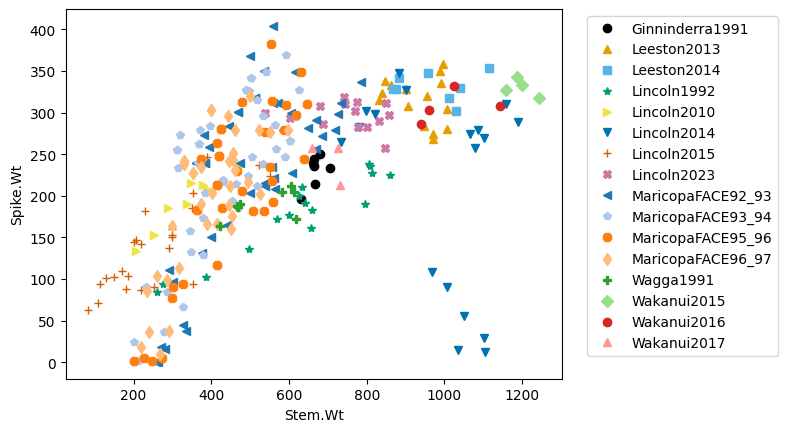

In [72]:
vars = ['Wheat.Spike.Wt','Wheat.Stem.Wt']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,vars[1]],exData.loc[:,vars[0]],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.ylabel('Spike.Wt')
plt.xlabel('Stem.Wt')

Text(0.5, 0, 'Phenology.Stage')

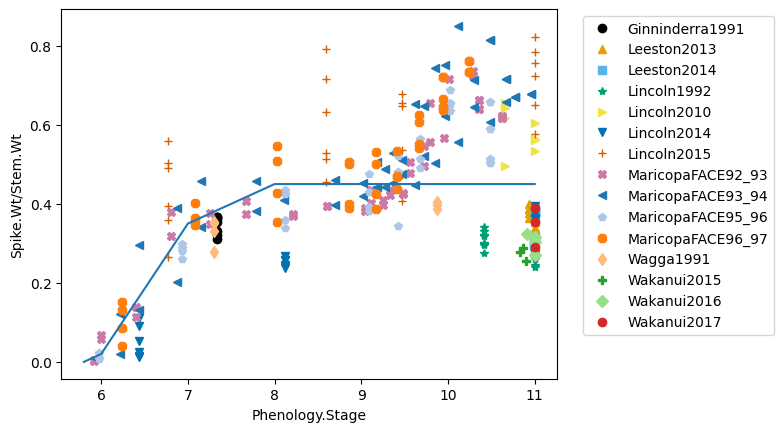

In [ ]:
vars = ['Wheat.Spike.Wt','Wheat.Phenology.Stage','Wheat.Stem.Wt']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Spike.Wt']/exData.loc[:,'Wheat.Stem.Wt'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.plot([5.8,6.0,7.0,8.0,11.0],
         [0.0,.02,.35,.45,.45],'-')
plt.ylabel('Spike.Wt/Stem.Wt')
plt.xlabel('Phenology.Stage')

Text(0.5, 0, 'Phenology.Stage')

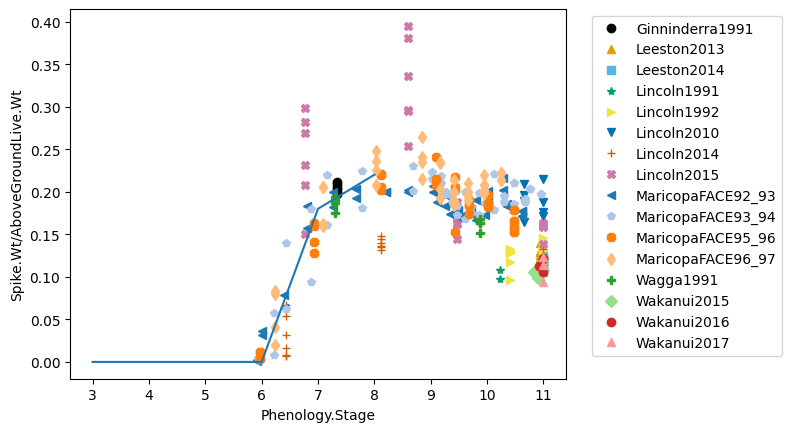

In [76]:
vars = ['Wheat.AboveGroundLive.Wt','Wheat.Phenology.Stage','Wheat.Spike.Wt']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Spike.Wt']/exData.loc[:,'Wheat.AboveGroundLive.Wt'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos > 16:
        mpos=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.plot([3.0,6,7.0,8.0,],
         [0,0,.18,.22],'-')
plt.ylabel('Spike.Wt/AboveGroundLive.Wt')
plt.xlabel('Phenology.Stage')


Text(0.5, 0, 'Stem.Wt')

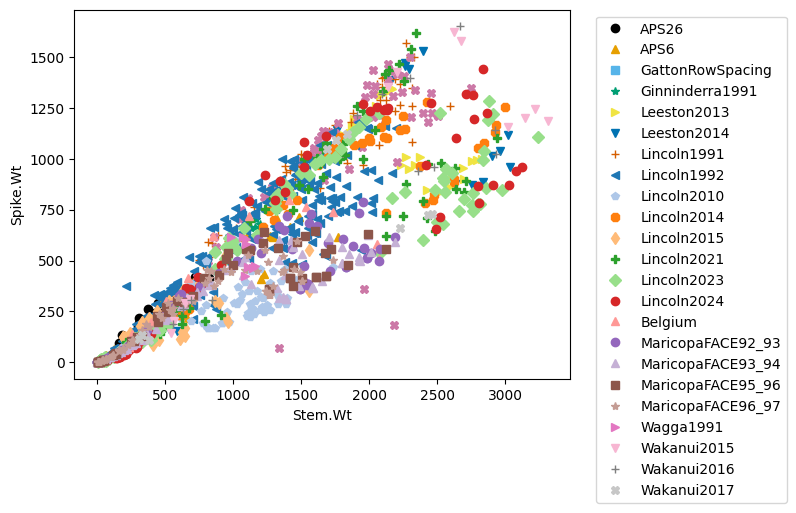

In [14]:
vars = ['Wheat.AboveGround.Wt','Wheat.Stem.Wt']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.AboveGround.Wt'],exData.loc[:,'Wheat.Stem.Wt'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos > 16:
        mpos=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.ylabel('Spike.Wt')
plt.xlabel('Stem.Wt')

(0.0, 0.9)

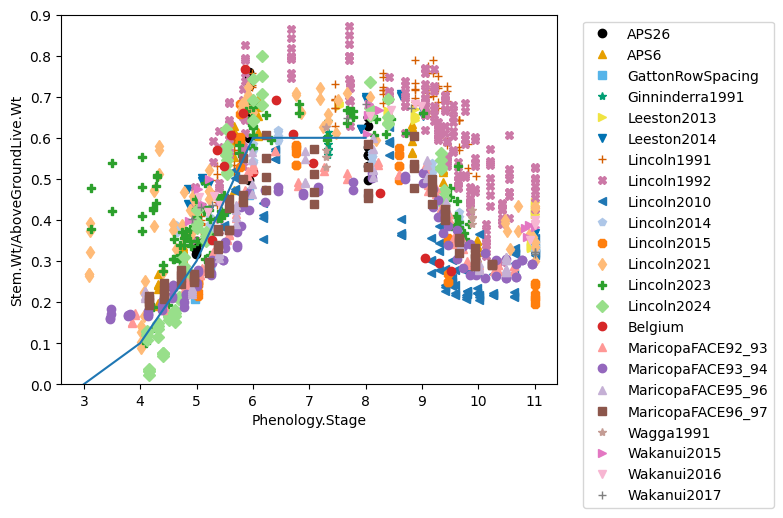

In [81]:
vars = ['Wheat.AboveGroundLive.Wt','Wheat.Phenology.Stage','Wheat.Stem.Wt']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Stem.Wt']/exData.loc[:,'Wheat.AboveGroundLive.Wt'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos > 16:
        mpos=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.plot([3.0,4.0,5.0,6.0,8.0],
         [0.0,.1,.3,.6,.6],'-')
plt.ylabel('Stem.Wt/AboveGroundLive.Wt')
plt.xlabel('Phenology.Stage')
plt.ylim(0,.9)

(0.0, 1.0)

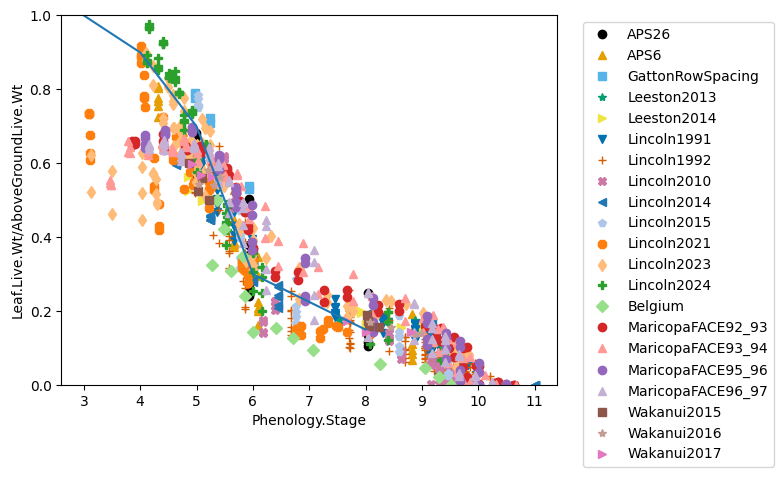

In [82]:
vars = ['Wheat.AboveGroundLive.Wt','Wheat.Phenology.Stage','Wheat.Leaf.Live.Wt']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.Live.Wt']/exData.loc[:,'Wheat.AboveGroundLive.Wt'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos > 16:
        mpos=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.plot([3.0,4.0,5.0,6.0,8.0],
         [1,.9,.7,.3,.15],'-')
plt.ylabel('Leaf.Live.Wt/AboveGroundLive.Wt')
plt.xlabel('Phenology.Stage')
plt.ylim(0,1)

Text(0.5, 0, 'Phenology.Stage')

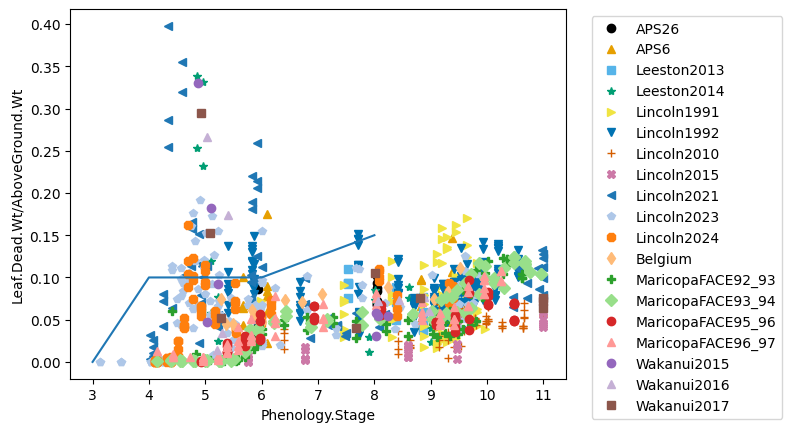

In [27]:
vars = ['Wheat.AboveGround.Wt','Wheat.Phenology.Stage','Wheat.Leaf.Dead.Wt']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.Dead.Wt']/exData.loc[:,'Wheat.AboveGround.Wt'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos > 16:
        mpos=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.plot([3.0,4.0,5.0,6.0,8.0],
         [0,.1,.1,.1,.15],'-')
plt.ylabel('Leaf.Dead.Wt/AboveGround.Wt')
plt.xlabel('Phenology.Stage')


Text(0.5, 0, 'Phenology.Stage')

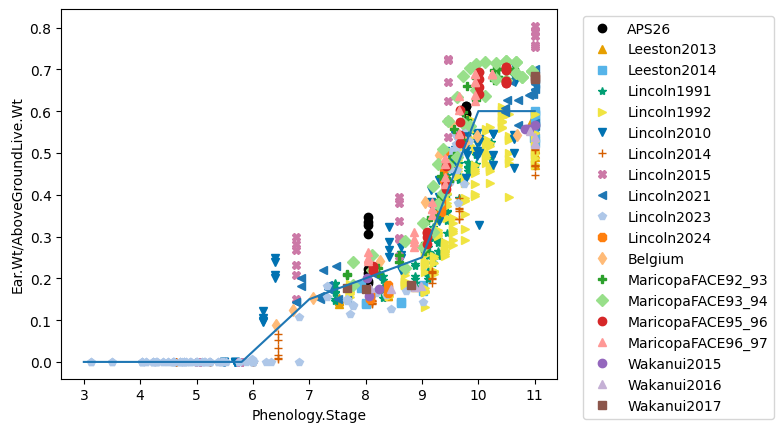

In [83]:
vars = ['Wheat.AboveGroundLive.Wt','Wheat.Phenology.Stage','Wheat.Ear.Wt']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Ear.Wt']/exData.loc[:,'Wheat.AboveGroundLive.Wt'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos > 16:
        mpos=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.plot([3.0,5.8,7.0,8.0,9.0,10,11],
         [0,0,.15,.2,.25,0.6,0.6],'-')
plt.ylabel('Ear.Wt/AboveGroundLive.Wt')
plt.xlabel('Phenology.Stage')


Text(0.5, 0, 'Phenology.Stage')

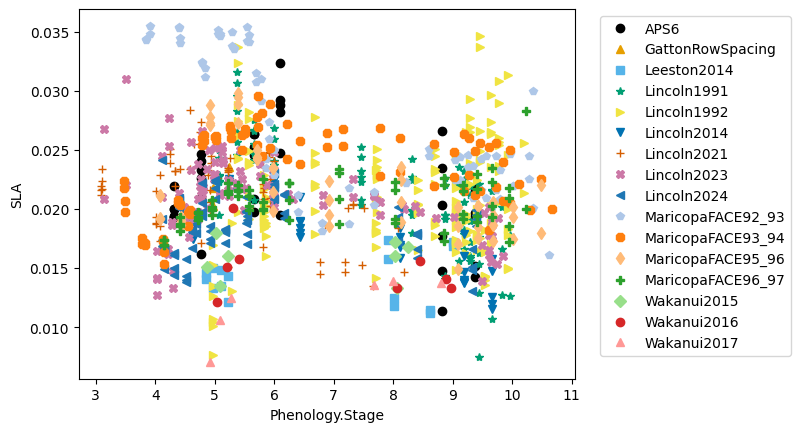

In [16]:
vars = ['Wheat.Leaf.SpecificAreaCanopy','Wheat.Phenology.Stage','IWeather.MaxT']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.SpecificAreaCanopy'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.ylabel('SLA')
plt.xlabel('Phenology.Stage')

Text(0.5, 0, 'Phenology.Stage')

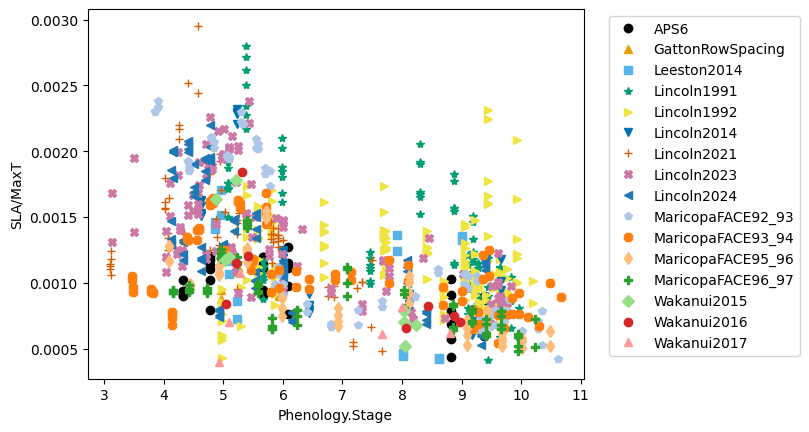

In [17]:
vars = ['Wheat.Leaf.SpecificAreaCanopy','Wheat.Phenology.Stage','IWeather.MaxT']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.SpecificAreaCanopy']/exData.loc[:,'IWeather.MaxT'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.ylabel('SLA/MaxT')
plt.xlabel('Phenology.Stage')

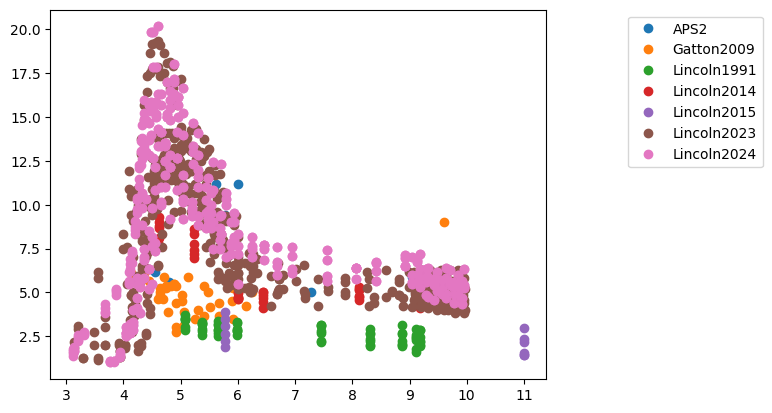

In [84]:
vars = ['Wheat.Leaf.StemNumberPerPlant','Wheat.Phenology.Stage','IWeather.MaxT']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.StemNumberPerPlant'],'o',label=e)
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)

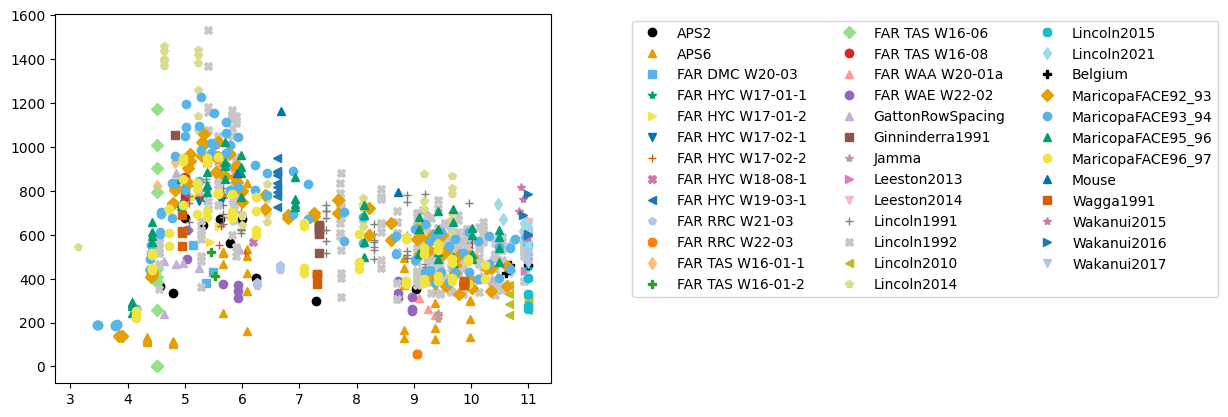

In [85]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.StemPopulation'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)

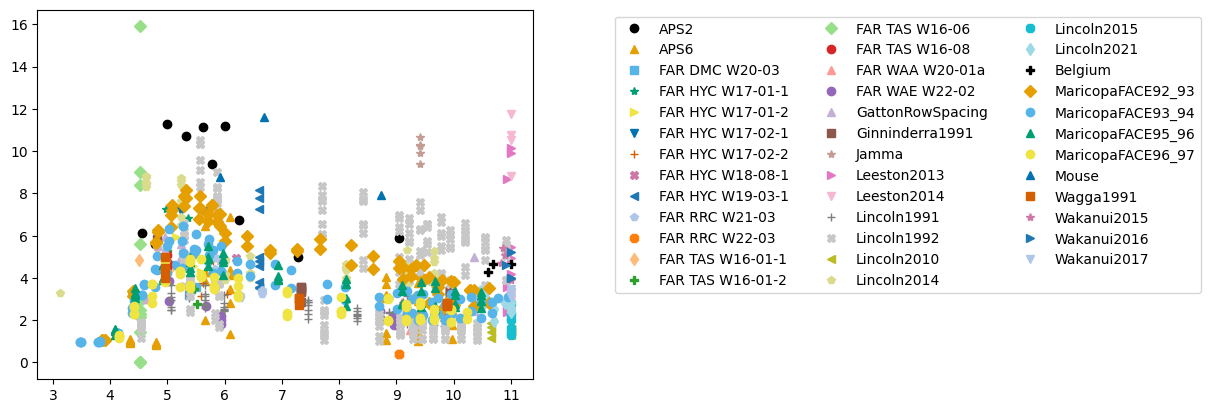

In [86]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage','Wheat.SowingData.Population','Wheat.Phenology.AccumulatedTT']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.StemPopulation']/exData.loc[:,'Wheat.SowingData.Population'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)

In [105]:
Observed.loc[:,['Wheat.Leaf.StemPopulation','Wheat.SowingData.Population','Wheat.Leaf.StemNumberPerPlant']]#.dropna(how='all')

Wheat.Leaf.StemPopulation  \
SimulationName                      Clock.Today                                      
12JuneeJames-1-100Cultivareaglehawk NaN                                        NaN   
12JuneeJames-1-100Cultivargregory   NaN                                        NaN   
12JuneeJames-1-50Cultivareaglehawk  NaN                                        NaN   
12JuneeJames-2-100Cultivareaglehawk NaN                                        NaN   
12JuneeJames-2-100Cultivargregory   NaN                                        NaN   
...                                                                            ...   
Yucheng04                           2005-06-07 12:00:00                        NaN   
                                    2005-06-08 12:00:00                        NaN   
                                    2005-06-11 12:00:00                        NaN   
                                    2005-06-17 12:00:00                        NaN   
                                    2005-06-22 12:00:00                        NaN   

                                                         Wheat.SowingData.Population  \
SimulationName                      Clock.Today                                        
12JuneeJames-1-100Cultivareaglehawk NaN                                          NaN   
12JuneeJames-1-100Cultivargregory   NaN                                          NaN   
12JuneeJames-1-50Cultivareaglehawk  NaN                                          NaN   
12JuneeJames-2-100Cultivareaglehawk NaN                                          NaN   
12JuneeJames-2-100Cultivargregory   NaN                                          NaN   
...                                                                              ...   
Yucheng04                           2005-06-07 12:00:00                        100.0   
                                    2005-06-08 12:00:00                        100.0   
                                    2005-06-11 12:00:00                        100.0   
                                    2005-06-17 12:00:00                        100.0   
                                    2005-06-22 12:00:00                        100.0   

                                                         Wheat.Leaf.StemNumberPerPlant  
SimulationName                      Clock.Today                                         
12JuneeJames-1-100Cultivareaglehawk NaN                                            NaN  
12JuneeJames-1-100Cultivargregory   NaN                                            NaN  
12JuneeJames-1-50Cultivareaglehawk  NaN                                            NaN  
12JuneeJames-2-100Cultivareaglehawk NaN                                            NaN  
12JuneeJames-2-100Cultivargregory   NaN                                            NaN  
...                                                                                ...  
Yucheng04                           2005-06-07 12:00:00                            NaN  
                                    2005-06-08 12:00:00                            NaN  
                                    2005-06-11 12:00:00                            NaN  
                                    2005-06-17 12:00:00                            NaN  
                                    2005-06-22 12:00:00                            NaN  

[41631 rows x 3 columns]

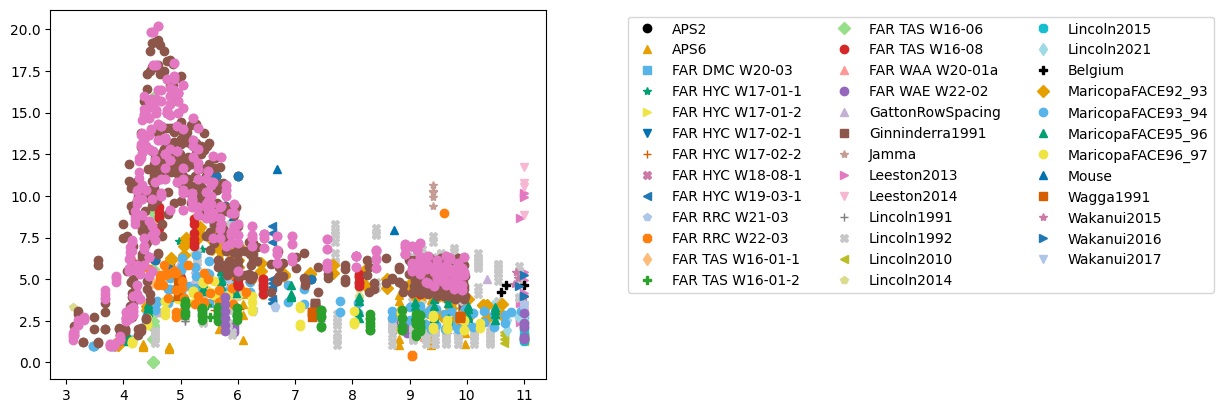

In [87]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage','Wheat.SowingData.Population','Wheat.Phenology.AccumulatedTT']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.StemPopulation']/exData.loc[:,'Wheat.SowingData.Population'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)

vars2 = ['Wheat.Leaf.StemNumberPerPlant','Wheat.Phenology.Stage','IWeather.MaxT']+['Experiment']
data2 = Observed.loc[:,vars2].dropna()
Experiments2 = data2.Experiment.drop_duplicates()
for e in Experiments2:
    exData = data2.loc[data2.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.StemNumberPerPlant'],'o',label=e)

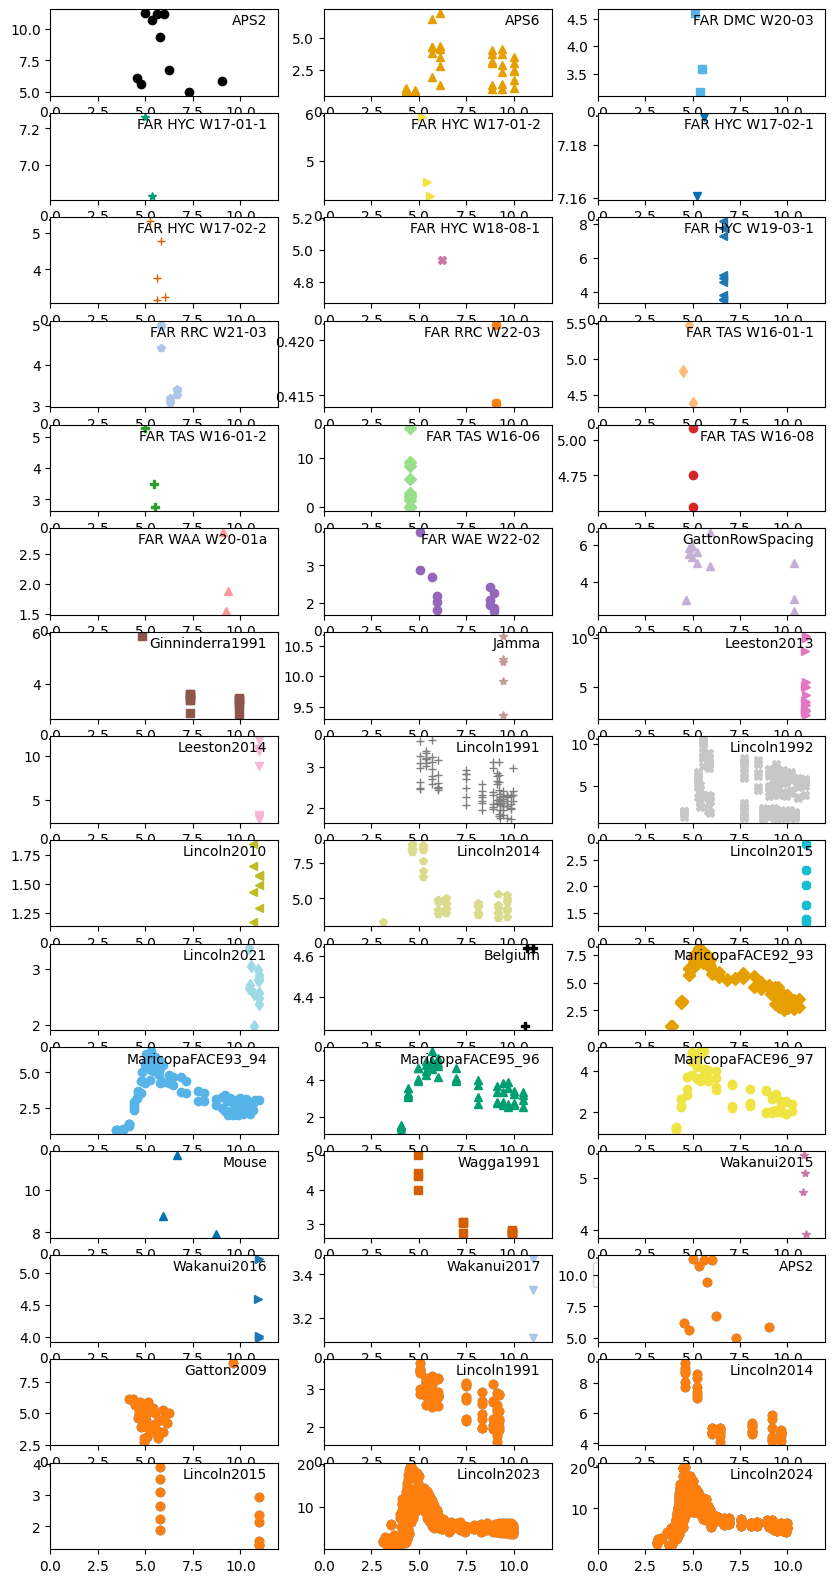

In [102]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage','Wheat.SowingData.Population','Wheat.Phenology.AccumulatedTT']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
pos=1
graph = plt.figure(figsize=(10,20))
for e in Experiments:
    ax = graph.add_subplot(15,3,pos)
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.StemPopulation']/exData.loc[:,'Wheat.SowingData.Population'],Markers[mpos],color=Colors[cpos],label=e)
    plt.text(0.95,0.95,e,transform = ax.transAxes,horizontalalignment='right', verticalalignment='top')
    plt.xlim(0,12)
    cpos+=1
    mpos+=1
    pos+=1               
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)

vars2 = ['Wheat.Leaf.StemNumberPerPlant','Wheat.Phenology.Stage','Wheat.Phenology.Stage','IWeather.MaxT']+['Experiment']
data2 = Observed.loc[:,vars2].dropna()
Experiments2 = data2.Experiment.drop_duplicates()
for e in Experiments2:
    ax = graph.add_subplot(15,3,pos)
    exData = data2.loc[data2.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.StemNumberPerPlant'],'o',label=e)
    plt.text(0.95,0.95,e,transform = ax.transAxes,horizontalalignment='right', verticalalignment='top')
    plt.xlim(0,12)
    pos+=1